# (LONDON MARKET) FINAL SUMMATIVE GROUP PROJECT

In [ ]:
## AUTHORS: Nana Kwaku Amoakoh, Kobina Kyereboah-Coleman
## 5th August 2024
## TODO: To develop an AI model for the prediction of product(cocoa) price for the London Market from the ICCO

## Downloading Necessary Modules

In [ ]:
!pip install scikit-learn
!pip install scikeras
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.0.2 scikeras

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
  Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.11.1 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.


## Importing Relevant Python Libraries

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
# from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.models import load_model
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

## Drive Mount

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

## Save Dataset To Google Drive

In [13]:
# Download the dataset
!wget -O /content/ICCO_daily_prices.csv 'https://raw.githubusercontent.com/nanadotam/ITAI/main/Final-Project/ICCO_daily_prices.csv'

--2024-08-05 17:49:26--  https://raw.githubusercontent.com/nanadotam/ITAI/main/Final-Project/ICCO_daily_prices.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 401764 (392K) [text/plain]
Saving to: ‘/content/ICCO_daily_prices.csv’

/content/ICCO_daily 100%[===================>] 392.35K  --.-KB/s    in 0.007s  

2024-08-05 17:49:26 (55.5 MB/s) - ‘/content/ICCO_daily_prices.csv’ saved [401764/401764]



## Load Dataset

In [ ]:
# Define the path to your CSV file in Google Drive
csv_path = '/content/drive/MyDrive/Colab Notebooks/ICCO Daily Prices.csv'

In [14]:
# Load the dataset
# data = pd.read_csv(csv_path)
data = pd.read_csv('/content/ICCO_daily_prices.csv')

## Data Preprocessing

In [15]:
# Select tuples with entries
data = data.iloc[0:7662]
data.head()

,Date,London futures (£ sterling/tonne),New York futures (US$/tonne),ICCO daily price (US$/tonne),ICCO daily price (Euro/tonne)
0,1/8/24,"5,282.67","6,709.33","6,730.95","6,239.26"
1,31/07/2024,"5,584.33","7,058.67","7,116.99","6,580.01"
2,30/07/2024,"5,662.00","7,141.00","7,205.50","6,666.17"
3,29/07/2024,"5,459.33","6,883.00","6,952.53","6,426.23"
4,26/07/2024,"5,611.00","7,054.33","7,139.25","6,575.60"


In [16]:
# Function to check for 30% data absence per column
def threshold(dataframe):

    # The data integrity threshold provided (30%)
    threshold = 0.3

    # Calculating threshold count for missing values
    threshold_count = int(threshold * len(dataframe))

    # Pulling out unsafe columns
    unsafe_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > threshold_count]
    if len(unsafe_columns) == 0:
        print("No columns have more than 30% missing values.")
    else:
        print(f"{len(unsafe_columns)} unsafe columns have been identified.")

    return unsafe_columns

In [17]:
threshold(data)

No columns have more than 30% missing values.


[]

In [18]:
# Function to identify columns with missing values
def find_null_columns(x):

    # Initialize empty list to store columns with null values
    null_columns = []

    # Iterate through all columns in the dataframe
    for col in x.columns:

        # Check if column has any null values
        if x[col].isnull().any():
            # Add column name to list if it contains nulls
            null_columns.append(col)
    if len(null_columns) > 0:
        # Print the list of columns with null values
        print(f"The following columns have null values: {null_columns}")
    else:
        print("No columns have null values.")
    print(null_columns)

In [19]:
find_null_columns(data)

No columns have null values.
[]


In [20]:
# Convert the 'Date' column to datetime without specifying a format
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

# Convert price columns to numeric (remove any commas and convert to float)
price_columns = ['London futures (£ sterling/tonne)', 'New York futures (US$/tonne)',
                 'ICCO daily price (US$/tonne)', 'ICCO daily price (Euro/tonne)']

# Use 'data' consistently instead of mixing it with 'df'
for col in price_columns:
    # Check if the column is of type object (likely string) before applying string operations
    if data[col].dtype == 'object':
        data[col] = pd.to_numeric(data[col].str.replace(',', ''), errors='coerce')
    else:
        print(f"Column '{col}' is not of string type. Skipping string replacement.")

In [21]:
# Sort the data by date
data = data.sort_values('Date')

In [22]:
# Convert 'Date' column to datetime without specifying a format, handling errors
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

# Check for any values that failed to convert (NaT)
failed_conversions = data[data['Date'].isna()]
if not failed_conversions.empty:
    print("Failed to convert the following dates:")
    print(failed_conversions)
    # Handle the failed conversions (e.g., try to fix the format, drop the rows, etc.)
    data = data.dropna(subset=['Date']) # Drop rows with invalid dates

# Continue with the rest of your code...
data['Days'] = (data['Date'] - data['Date'].min()).dt.days # Use df instead of data

In [23]:
# Choose which market to predict (London or New York)
market = 'London futures (£ sterling/tonne)'

In [24]:
# Choose which market to predict (London or New York)
market = 'London futures (£ sterling/tonne)'

# NO CHANGES NEEDED HERE.  The price data was already cleaned in a previous step.
# Clean the price data: remove commas and convert to float
# data[market] = data[market].str.replace(',', '').astype(float)

# Verify the data type of the market column
print(data[market].dtype)

float64


In [25]:
# Display information about the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7662 entries, 7661 to 0
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               7662 non-null   datetime64[ns]
 1   London futures (£ sterling/tonne)  7662 non-null   float64       
 2   New York futures (US$/tonne)       7662 non-null   float64       
 3   ICCO daily price (US$/tonne)       7662 non-null   float64       
 4   ICCO daily price (Euro/tonne)      7662 non-null   float64       
 5   Days                               7662 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 419.0 KB


In [26]:
# Calculate moving averages
data['MA_7'] = data[market].rolling(window=7).mean()
data['MA_30'] = data[market].rolling(window=30).mean()
data['MA_90'] = data[market].rolling(window=90).mean()

In [27]:
# Calculate price differences
data['Price_Diff'] = data[market].diff()

In [28]:
# Calculate volatility measures (standard deviation over rolling windows)
data['Volatility_7'] = data[market].rolling(window=7).std()
data['Volatility_30'] = data[market].rolling(window=30).std()
data['Volatility_90'] = data[market].rolling(window=90).std()

In [33]:
data.to_csv('/content/ldn_cleaned_data.csv', index=False)

In [29]:
# Calculate a 'Days' column if it doesn't exist (assuming you want a simple day counter)
data['Days'] = range(1, len(data) + 1)

# Prepare X and y
X = data[['Days', 'MA_7', 'MA_30', 'MA_90', 'Price_Diff', 'Volatility_7', 'Volatility_30', 'Volatility_90']]
y = data[market]

In [30]:
# Handle missing values in features
X = X.fillna(0)

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Reshape the data for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
 # Run with the adjusted parameters
for i in range(1):
    history = lstm_model.fit(X_train_lstm, y_train, epochs = 100, batch_size = 32, validation_data=(X_test_lstm, y_test), verbose=1)
    y_pred_lstm = lstm_model.predict(X_test_lstm)
    mse_lstm = mean_squared_error(y_test, y_pred_lstm)
    r2_lstm = r2_score(y_test, y_pred_lstm)
    mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
    print(f'LSTM Iteration {i+1}\nMean squared error: {mse_lstm}, R-squared score: {r2_lstm}, Mean absolute error: {mae_lstm}')

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3005239.2500 - val_loss: 2826663.0000
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2963031.7500 - val_loss: 2788369.0000
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2879152.2500 - val_loss: 2717727.0000
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2877010.7500 - val_loss: 2620494.5000
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2827073.5000 - val_loss: 2505479.0000
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2597255.0000 - val_loss: 2372636.7500
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2533502.0000 - val_loss: 2228964.0000
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2386026.2500 - val_loss: 2077095.1250
Epoch 9/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2217885.0000 - val_loss: 1922124.6250
Epoch 10/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2004981.5000 - val_loss: 1766770.8750
Epoch 11/

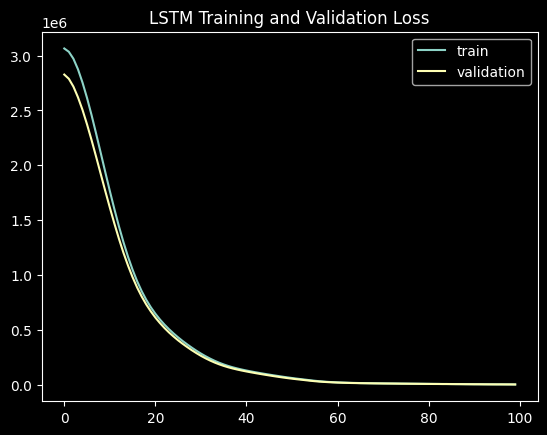

In [ ]:
# Plot training history for the last iteration
plt.style.use('dark_background')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.show()

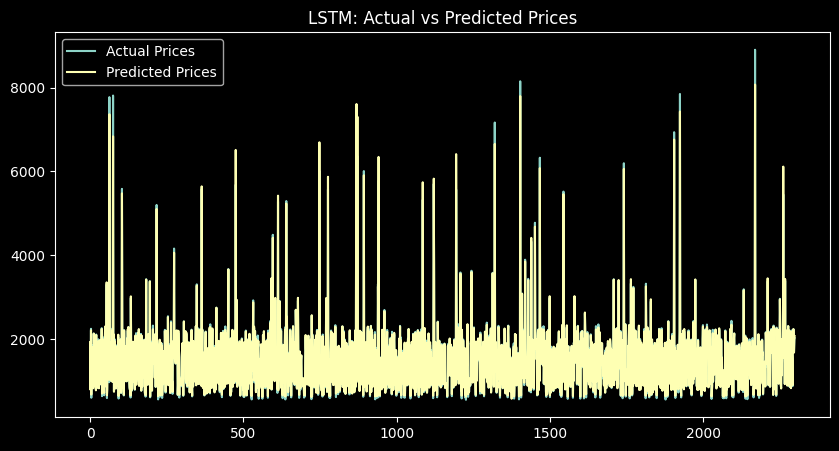

In [ ]:
# Plot LSTM results
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Prices')
plt.plot(y_pred_lstm, label='Predicted Prices')
plt.title('LSTM: Actual vs Predicted Prices')
plt.legend()
plt.show()

In [ ]:
# Save the LSTM model
model_path = '/content/drive/MyDrive/cocoa_price_lstm_model.keras'
lstm_model.save(model_path)

# Save the scaler separately using pickle
scaler_path = '/content/drive/MyDrive/cocoa_price_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")

Model saved to /content/drive/MyDrive/cocoa_price_lstm_model.keras
Scaler saved to /content/drive/MyDrive/cocoa_price_scaler.pkl
